# Digit&nbsp;Classification with a Deep Convolutional&nbsp;Neural&nbsp;Network
by Karl J. Obermeyer

In this project, I implemented a deep CNN (Convolutional Neural Network) in TensorFlow to classify numeric digits. The main code is in this Jupyter notebook and the custom python module `image_recognition_tools.py`. The notebook can be run according to the instructions in `README.md`. Images used for training, validation, and testing are from the [MNIST](http://yann.lecun.com/exdb/mnist/) database of handwritten digits. The network architecture is based loosely on [LeNet-5](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf). Initially I experimented with a CNN that was essentially the same as LeNet-5.  This baseline CNN achieved a mere ??.?% classification accuracy on the validation set. To improve performance, I took the following steps:

  1. Increased the depth of convolutional filters,  
  2. Added more nodes to fully connected layers, and  
  3. Added dropout regularization. 

The final trained CNN achieved 9?.?% classification accuracy on the MNIST test set. Examining the top few softmax probabilities for the independently obtained images showed that the CNN did have a small amount of uncertainty in distinguishing between digits that were geometrically similar and look similar, in most cases, even to humans. Avenues for future work include trying different network topologies, preprocessing (e.g. edge detection), data augmentation.

In [1]:
#%qtconsole  # For inspecting variables.

In [2]:
# Standard
import os
from glob import glob  # Unix style pathname pattern expansion.
import csv
import pickle
import time

# Scientific Computing and Visualization
import numpy as np; np.random.seed(13)  # Lucky seed.
import matplotlib.pyplot as plt
%matplotlib inline
import cv2  # Image processing.

# Machine Learning
#from sklearn.utils import shuffle  # Used numpy's shuffle instead.
#from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.contrib.layers import flatten

# Project-Specific.
# Includes custom functions for
# image processing, data manipulation, and dataset visualization.
from image_recognition_tools import *

## 0&nbsp;&nbsp;&nbsp;Load Data

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
def convert_mnist_dataset_to_standard_form(data):
    '''Map pixel values into [0, 255].
    '''
    example_cnt = data.images.shape[0]
    images = 255.0*data.images
    np.round(images, out=images)
    np.clip(images, 0.0, 255.0, out=images)
    X = np.reshape(images, newshape=(example_cnt, 28, 28, 1)).astype(np.uint8)
    y = np.argmax(data.labels, axis=1).astype(np.uint8)
    return X, y

In [5]:
X_train, y_train = convert_mnist_dataset_to_standard_form(mnist.train)
X_train, y_train = shuffle(X_train, y_train)

In [6]:
X_validate, y_validate = convert_mnist_dataset_to_standard_form(mnist.validation)
X_validate, y_validate = shuffle(X_validate, y_validate)

In [7]:
X_test, y_test = convert_mnist_dataset_to_standard_form(mnist.test)
X_test, y_test = shuffle(X_test, y_test)

## 1&nbsp;&nbsp;&nbsp;Dataset Summary, Exploration, and&nbsp;Balancing

### Sizes and Shapes

In [8]:
# Number of training examples.
training_example_cnt = X_train.shape[0]

# Number of validation examples.
validation_example_cnt = X_validate.shape[0]

# Number of testing examples.
test_example_cnt = X_test.shape[0]

# List of unique class labels.
class_list = list(set(y_train) | set(y_validate) | set(y_test))
class_list.sort()

# Number of classes in the dataset.
class_cnt = len(class_list)  # Should be 0,...,42

# Single image shape.
image_shape = X_train[0, :].shape

print('Number of training examples =', training_example_cnt)
print('Number of validation examples =', validation_example_cnt)
print('Number of testing examples =', test_example_cnt)
print('Number of classes =', class_cnt)
print('Image shape =', image_shape)

Number of training examples = 55000
Number of validation examples = 5000
Number of testing examples = 10000
Number of classes = 10
Image shape = (28, 28, 1)


### Exploratory Visualization

To get an idea of what typical images look like, we synthesize a summary image from all example images in each class (training, validation and testing images combined).  The summary image could be created in a variety of ways, e.g., by choosing one example, taking the pixelwise mean, or the pixelwise median.  We use the pixelwise mean here.  In order to compute the mean, we first make a dict, `images_by_label` which allows easy access to all images by label.  Keys of this dict are labels and each value is a large numpy array containing all images of the corresponding label.

In [9]:
X_all, y_all = combine(
    X_train, y_train, X_validate, y_validate, X_test, y_test)
images_by_label = sort_by_class(X_all, y_all, class_list)

And now we compute and display the means, one for each label.

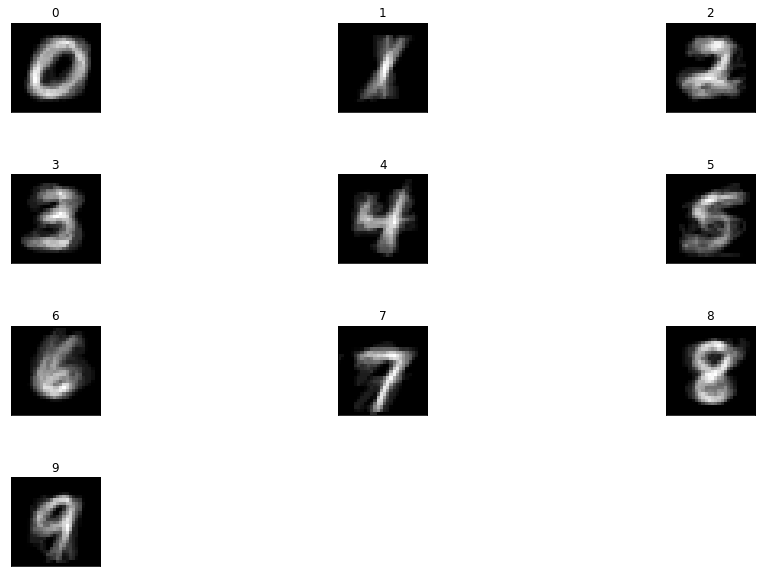

In [10]:
plot_representative_images(
    images_by_label, class_cnt=class_cnt, english_labels=None, method='mean')
#plt.savefig('./fig/class_representative_images.png')

Next, let's see how balanced the data are by making histograms of the labels in each of the different subsets of the data.

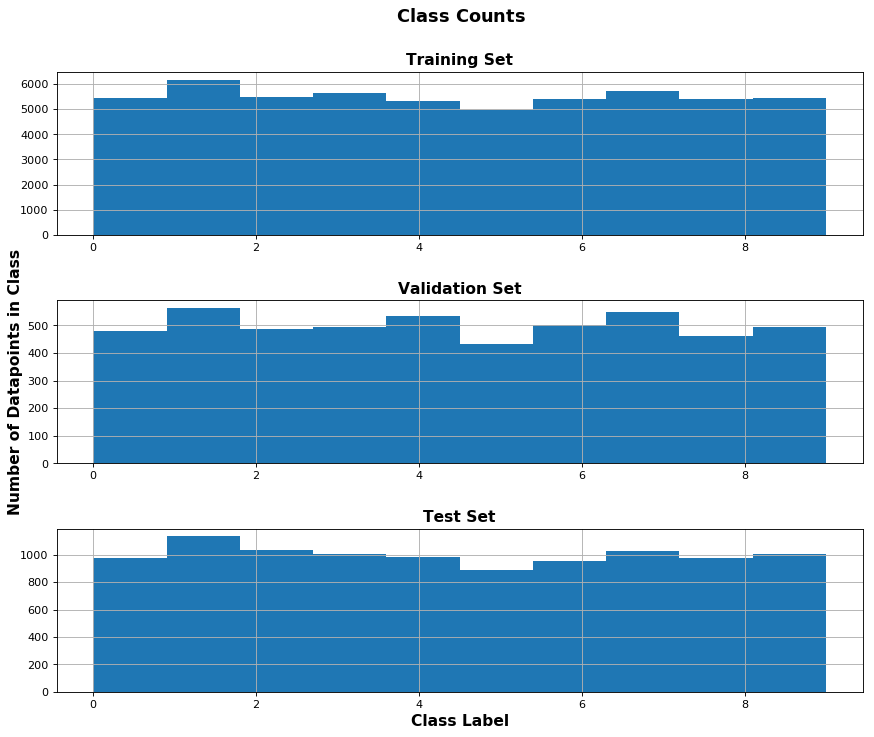

In [11]:
class_histograms(y_train, y_validate, y_test, class_cnt=class_cnt)
#plt.savefig('./fig/class_histograms.png')

The classes have roughly equal representation both within each subset (train, validate, test) and across subsets.  This is good because otherwise we would have to worry about unbalanced data leading to a classifier which is biased away from under-represented classes. We may still benefit from augmenting the datasets by synthesizing new images.

### Data Augmentation

To create a larger dataset, we augment the data by stratified sampling together with random image perturbation.  Image perturbation is implemented in the `randomly_perturb` function in `image_recognition_tools.py`.  Images are perturbed by random changes in brightness, rotation, translation, and shear.  This helps train the CNN to classify images captured under a greater variety of conditions.

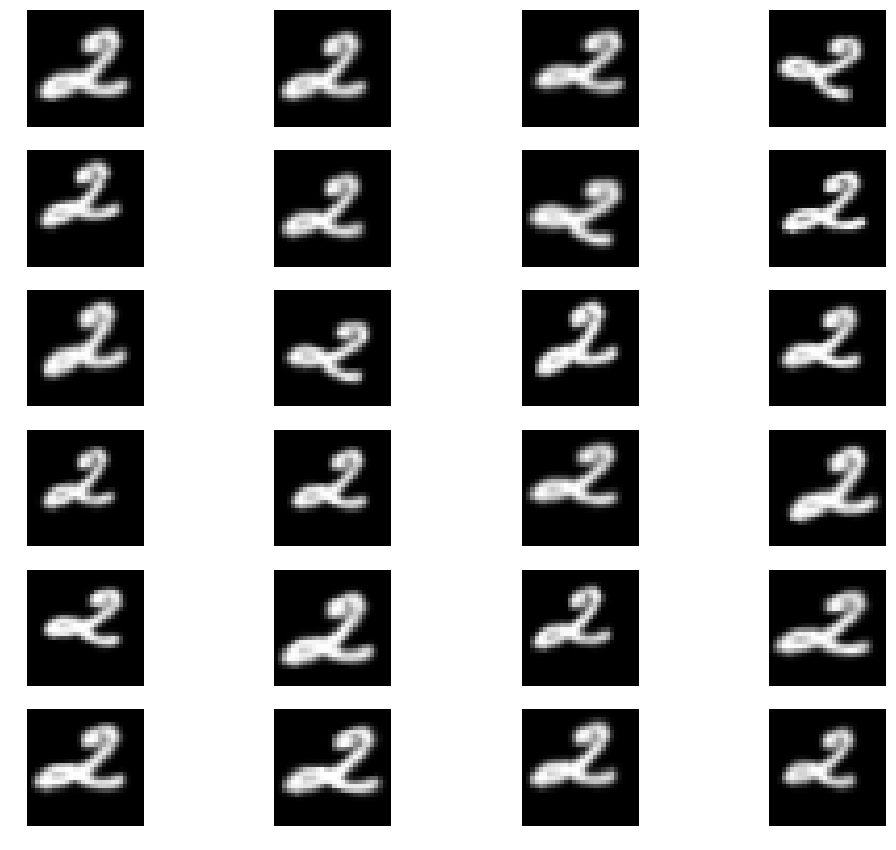

In [12]:
image = X_train[100, :]
test_randomly_perturb(
    image,
    brightness_radius=0.3,
    rotation_radius=30.0,
    translation_radius=3,
    shear_radius=3)
#plt.savefig('./fig/image_perturbations_example.png')

In [13]:
DATAPOINTS_PER_CLASS_AFTER_AUGMENTATION = 7000  # Default 7000.
X_train_augmented, y_train_augmented = balance(
    X_train, y_train, class_list,
    datapoint_cnt_per_class=DATAPOINTS_PER_CLASS_AFTER_AUGMENTATION,
    perturb=True)

In [14]:
print('Number of augmented training examples =', len(y_train_augmented))

Number of augmented training examples = 70000


## 2&nbsp;&nbsp;&nbsp;CNN Architecture&nbsp;and&nbsp;Testing

We use an architecture based on [LeNet-5](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf).  Like LeNet-5, we have a 10-class output. Modifying LeNet-5 only by ... resulted in a ??.?% test accuracy. To improve performance, we increased the depth of the convolution filters, increased the size of the fully connected layers, and added dropout regularization as in the figure below. With these changes, we achieve a test accuracy of ??.?%.

<img src="./fig/cnn_architecture-horizontal.png" alt="Drawing" style="width: 700px; margin: 0 auto"/>

### Image Preprocessing: Brightness Equalization and&nbsp;Normalization.

Brightness equalization using the histogram technique, implemented in OpenCV, should help our CNN perform more consistantly accross varying lighting conditions. Normalizing pixel values to the range [-1.0, 1.0] helps mitigate optimization problems that can be caused by scale differences between features learned by the CNN.

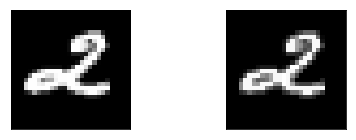

In [15]:
test_histogram_equalize_brightness(X_train[100, :])

In [16]:
def preprocess(X):
    '''Prepare numpy array of images for input into CNN.
    
    Args:
        X: numpy array of images, e.g., as X_train,
          X_validate, or X_test.
    
    Returns:
        X_in: numpy array of normalized gray images.
    '''
    X_in = np.zeros(
        (X.shape[0], X.shape[1], X.shape[2], 1), dtype=np.float32)

    for i, image in enumerate(X):
        image = histogram_equalize_brightness(image)
        #X_in[i, :] = normalize(image)[:, :, None]  # Adds degenerate dimension.
        X_in[i, :] = normalize(image)
            
    return X_in

We use `_in` to denote preprocessed versions of data because it is what is feed *in*to the neural network proper.

In [17]:
TRAIN_WITH_AUGMENTED_DATA = False
if TRAIN_WITH_AUGMENTED_DATA:
    X_train_augmented_in = preprocess(X_train_augmented)
    X_train_in = X_train_augmented_in
    y_train = y_train_augmented
else:
    X_train_in = preprocess(X_train)

In [18]:
X_validate_in = preprocess(X_validate)

In [19]:
X_test_in = preprocess(X_test)

### TensorFlow Graph Definition

In [20]:
def kjo_net(X_in, keep_probability):
    '''CNN Architecture.
    
    Args:
        X_in: tf.placeholder(tf.float32, (None, 28, 28, 1)), preprocessed images.
        keep_probability: tf.placeholder(tf.float32), probability of keeping nodes
            during dropout.
    
    Returns:
        logits
    '''
    # Hyperparameters used with tf.truncated_normal to set random
    # initial values of the weights and biases in each layer.
    mu = 0.0  # Default 0.0
    sigma = 0.1  # Default 0.1
    #
    # If using ReLU activations, initialize with slight positive bias, e.g., 0.1,
    # to avoid "dead neurons". 
    initial_bias = 0.05
    
    
    # Layer 1: Convolutional, 28x28x1 --> 24x24x16.
    # In nominal LeNet was 32x32x1 --> 28x28x6.
    # shape := (
    #   filter_height,
    #   filter_width,
    #   input_depth aka input_channel_cnt,
    #   output_depth aka output_channel_cnt).
    conv1_W = tf.Variable(
        tf.truncated_normal(shape=(5, 5, 1, 16), mean=mu, stddev=sigma),
        name='conv1_W')
    conv1_b = tf.Variable(tf.zeros(16) + initial_bias, name='conv1_b')
    conv1 = tf.nn.conv2d(
        X_in, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    conv1 = tf.nn.relu(conv1)  # Activation.
    #
    # Pooling. 24x24x16 --> 12x12x16.
    # In nominal LeNet was 28x28x6 --> 14x14x6.
    conv1 = tf.nn.max_pool(
        conv1, ksize=[1, 2, 2, 1],
        strides=[1, 2, 2, 1], padding='VALID')

    
    # Layer 2: Convolutional, 12x12x16 --> 8x8x32.
    # In nominal LeNet was 14x14x6 --> 10x10x16.
    conv2_W = tf.Variable(
        tf.truncated_normal(shape=(5, 5, 16, 32), mean=mu, stddev=sigma),
        name='conv2_W')
    conv2_b = tf.Variable(tf.zeros(32) + initial_bias, name='conv2_b')
    conv2 = tf.nn.conv2d(
        conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    conv2 = tf.nn.relu(conv2)  # Activation.
    #
    # Pooling, 8x8x32 --> 4x4x32.
    # In nominal LeNet was 10x10x16 --> 5x5x16.
    conv2 = tf.nn.max_pool(
        conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    
    # Flatten layer, 4x4x32 --> 512.
    # In nominal LeNet was 5x5x16 --> 400.
    # Flattens tensor into 2 dimensions (batches, length).
    fc0 = flatten(conv2)
    
    
    # Layer 3: Fully Connected, 512 --> 400.
    # In nominal LeNet was 400 --> 120.
    fc1_W = tf.Variable(
        tf.truncated_normal(shape=(512, 400), mean=mu, stddev=sigma),
        name='fc1_W')
    fc1_b = tf.Variable(tf.zeros(400) + initial_bias, name='fc1_b')
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b
    fc1 = tf.nn.relu(fc1)  # Activation.
    #
    # Dropout. 
    fc1 = tf.nn.dropout(fc1, keep_probability)
    
    
    # Layer 4: Fully Connected, 400 --> 300.
    # In nominal LeNet was 120 --> 84.
    fc2_W = tf.Variable(
        tf.truncated_normal(shape=(400, 300), mean=mu, stddev=sigma),
        name='fc2_W')
    fc2_b = tf.Variable(tf.zeros(300) + initial_bias, name='fc2_b')
    fc2 = tf.matmul(fc1, fc2_W) + fc2_b
    fc2 = tf.nn.relu(fc2)  # Activation.
    # Dropout. 
    fc2 = tf.nn.dropout(fc2, keep_probability)
    
    
    # Layer 5: Fully Connected, 300 --> class_cnt (default 10).
    # In nominal LeNet was 84 --> 10.
    fc3_W = tf.Variable(
        tf.truncated_normal(shape=(300, class_cnt), mean=mu, stddev=sigma),
        name='fc3_W')
    fc3_b = tf.Variable(tf.zeros(class_cnt) + initial_bias, name='fc3_b')
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    
    return logits

### Training and Validation

The code in this section was used to perform validation runs to determine a good `KEEP_PROBABILITY` value for dropout regularization.  Of the validated values, 0.4 was the best and was used for final testing.  Note: output from validation sessions has been omitted as it was extremely long.  Only the output of the final training session is included in the next section.

In [21]:
# Hyperparameters.
LEARNING_RATE = 0.001 # Default 0.001
EPOCH_CNT = 30  # Number of times to run over training data. Default 30.
BATCH_SIZE = 256  # Datapoints to consider per backprop pass. Default 256.
KEEP_PROBABILITY = 0.3  # For dropout regularization.  Try 0.5, 0.6, 0.7, 1.0

In [22]:
# Input images and output labels.
X_in = tf.placeholder(tf.float32, (None, 28, 28, 1))  # None => arbitrary batch size.
y = tf.placeholder(tf.int32, (None))  # None => arbitrary batch size.
keep_probability = tf.placeholder(tf.float32)
y_one_hot = tf.one_hot(y, class_cnt)
#keep_probability = tf.placeholder(tf.float32)

In [23]:
logits = kjo_net(X_in, keep_probability)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=y_one_hot, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)
training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y_one_hot, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [24]:
# To save parameters for re-use.
saver = tf.train.Saver()  # Must be initialized after tf symbolic variables.
validation_save_filename = './kjo_net.validation.ckpt'

In [25]:
def compute_accuracy(session, X_in_, y_):
    '''Compute model accuracy.
    
    ::WARNING:: The trailing underscores on the argument variable names
    are to prevent collision with global tensoflow variables X_in and y.
    
    Args:
        session: tf.session.
        X_in_: np.array, preprocessed inputs.
        y_: np.array, outputs corresponding to X_in.
        
    Returns:
        float, accuracy of model applied to (X_in, y).
    '''
    
    #session = tf.get_default_session()
    example_cnt = len(X_in_)
    total_accuracy = 0
    for offset in range(0, example_cnt, BATCH_SIZE):
        batch_X_in, batch_y = \
            X_in_[offset:offset+BATCH_SIZE], \
            y_[offset:offset+BATCH_SIZE]
        accuracy = session.run(
            accuracy_operation,
            feed_dict={X_in: batch_X_in, y: batch_y, keep_probability: 1.0})
        total_accuracy += (accuracy * len(batch_X_in))
        
    return total_accuracy / example_cnt

In [ ]:
start_time = time.time()
accuracies_train = []
accuracies_validate = []

with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    example_cnt = len(X_train_in)
    print('Training...\n')
    for i in range(EPOCH_CNT):
        
        X_train_in, y_train = shuffle(X_train_in, y_train)
        for offset in range(0, example_cnt, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_X_in, batch_y = X_train_in[offset:end], y_train[offset:end]
            session.run(
                training_operation,
                feed_dict={X_in: batch_X_in, y: batch_y, keep_probability: KEEP_PROBABILITY})
            
        accuracy_train = compute_accuracy(session, X_train_in, y_train)
        accuracies_train.append(accuracy_train)
        
        accuracy_validate = compute_accuracy(session, X_validate_in, y_validate)
        accuracies_validate.append(accuracy_validate)
        
        print('EPOCH {} ...'.format(i+1))
        #print("Loss = {:.3f}".format(loss))
        print('Training Accuracy = {:.3f}'.format(accuracy_train))
        print('Validation Accuracy = {:.3f}'.format(accuracy_validate))
        print()
        
    saver.save(session, validation_save_filename)
    print("Model saved")

dt_s = time.time() - start_time
dt_m = dt_s / 60.0
dt_h = dt_s / 3600.0
print('Wallclock time elapsed:' \
    ' {:.3f} s = {:.3f} m = {:.3f} h.'.format(dt_s, dt_m, dt_h))

In [ ]:
# Plot accuracies vs epoch.
plt.plot(
    np.arange(EPOCH_CNT), accuracies_train,
    label='training accuracy', zorder=0, linewidth=3)
plt.plot(
    np.arange(EPOCH_CNT), accuracies_validate,
    label='validation accuracy', zorder=0, linewidth=3)
plt.title('Accuracies vs Epoch', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy', fontsize=14, fontweight='bold')
legend = plt.legend(numpoints=1)
plt.setp(legend.get_texts(), fontsize='14', fontweight='bold')
ax = plt.gca()
#plt.axis('equal') # Defective so use set_aspect instead?
#ax.set_aspect('equal', adjustable='box')
ax.margins(0.1)
#ax.set_yscale('log')
#ax.autoscale(tight=True)
#plt.xlim((0, 2000.0))
#plt.ylim((0, 1000.0))
plt.grid(True)
plt.show()
#plt.savefig('./fig/accuracies_vs_epoch.png')

In [ ]:
with tf.Session() as session:
    #saver = tf.train.import_meta_graph('kjo_net.meta')
    #saver.restore(session, tf.train.latest_checkpoint('.'))
    saver.restore(session, validation_save_filename)
    test_accuracy = compute_accuracy(session, X_test_in, y_test)
    print('Test Accuracy = {:.3f}'.format(test_accuracy))

### Final Training and Testing

In this section we add the balanced validation set to the balanced training set and re-train to get the final network parameters. This should only be done for the final training, i.e., after architecture and hyperparameters have been fixed based on validation performance. If you do not wait to combine training and validation sets until the final training, then you are data snooping!

In [26]:
X_train_final_in, y_train_final = combine(
    X_train_in, y_train, X_validate_in, y_validate)
print('Number of datapoints in final training set:', len(y_train_final)) 

Number of datapoints in final training set: 60000


In [27]:
# To save parameters for re-use.
testing_save_filename = './kjo_net.testing.ckpt'

In [28]:
start_time = time.time()
accuracies_train = []
accuracies_test = []

with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    example_cnt = len(X_train_final_in)
    print('Training...\n')
    for i in range(EPOCH_CNT):
        
        X_train_final_in, y_train_final = shuffle(X_train_final_in, y_train_final)
        for offset in range(0, example_cnt, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_X_in, batch_y = X_train_final_in[offset:end], y_train_final[offset:end]
            session.run(
                training_operation,
                feed_dict={X_in: batch_X_in, y: batch_y, keep_probability: KEEP_PROBABILITY})
            
        accuracy_train = compute_accuracy(session, X_train_final_in, y_train_final)
        accuracies_train.append(accuracy_train)
        
        accuracy_test = compute_accuracy(session, X_test_in, y_test)
        accuracies_test.append(accuracy_test)

        print('EPOCH {} ...'.format(i+1))
        #print("Loss = {:.3f}".format(loss))
        print('Training Accuracy = {:.3f}'.format(accuracy_train))
        print('Test Accuracy = {:.3f}'.format(accuracy_test))
        print()
        
    saver.save(session, testing_save_filename)
    print("Model saved")

dt_s = time.time() - start_time
dt_m = dt_s / 60.0
dt_h = dt_s / 3600.0
print('Wallclock time elapsed:' \
    ' {:.3f} s = {:.3f} m = {:.3f} h.'.format(dt_s, dt_m, dt_h))

Training...

EPOCH 1 ...
Training Accuracy = 0.959
Test Accuracy = 0.961

EPOCH 2 ...
Training Accuracy = 0.978
Test Accuracy = 0.977

EPOCH 3 ...
Training Accuracy = 0.984
Test Accuracy = 0.982

EPOCH 4 ...
Training Accuracy = 0.985
Test Accuracy = 0.983

EPOCH 5 ...
Training Accuracy = 0.988
Test Accuracy = 0.987

EPOCH 6 ...
Training Accuracy = 0.991
Test Accuracy = 0.988

EPOCH 7 ...
Training Accuracy = 0.992
Test Accuracy = 0.989

EPOCH 8 ...
Training Accuracy = 0.994
Test Accuracy = 0.989

EPOCH 9 ...
Training Accuracy = 0.994
Test Accuracy = 0.990

EPOCH 10 ...
Training Accuracy = 0.994
Test Accuracy = 0.989

EPOCH 11 ...
Training Accuracy = 0.995
Test Accuracy = 0.990

EPOCH 12 ...
Training Accuracy = 0.995
Test Accuracy = 0.991

EPOCH 13 ...
Training Accuracy = 0.996
Test Accuracy = 0.992

EPOCH 14 ...
Training Accuracy = 0.996
Test Accuracy = 0.991

EPOCH 15 ...
Training Accuracy = 0.996
Test Accuracy = 0.991

EPOCH 16 ...
Training Accuracy = 0.996
Test Accuracy = 0.992

EPOC

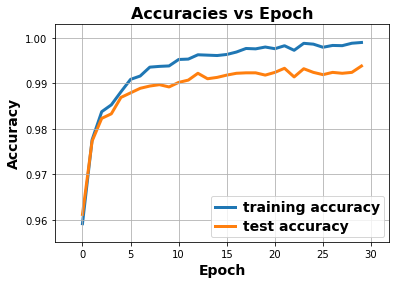

In [29]:
# Plot accuracies vs epoch.
plt.plot(
    np.arange(EPOCH_CNT), accuracies_train,
    label='training accuracy', zorder=0, linewidth=3)
plt.plot(
    np.arange(EPOCH_CNT), accuracies_test,
    label='test accuracy', zorder=0, linewidth=3)
plt.title('Accuracies vs Epoch', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy', fontsize=14, fontweight='bold')
legend = plt.legend(numpoints=1)
plt.setp(legend.get_texts(), fontsize='14', fontweight='bold')
ax = plt.gca()
#plt.axis('equal') # Defective so use set_aspect instead?
#ax.set_aspect('equal', adjustable='box')
ax.margins(0.1)
#ax.set_yscale('log')
#ax.autoscale(tight=True)
#plt.xlim((0, 2000.0))
#plt.ylim((0, 1000.0))
plt.grid(True)
#plt.savefig('./fig/accuracies_vs_epoch-final.png')

Since the gap between training and test accuracy is relatively small, and the accuracies increased roughly monotonically during training, I believe the model is well-fitting (i.e. not over- or underfitting).

## 3&nbsp;&nbsp;&nbsp;Examining&nbsp;Performance on Individual&nbsp;Images

We now examine our classifier's performance on 5 individual test images.

### Load and Plot Images

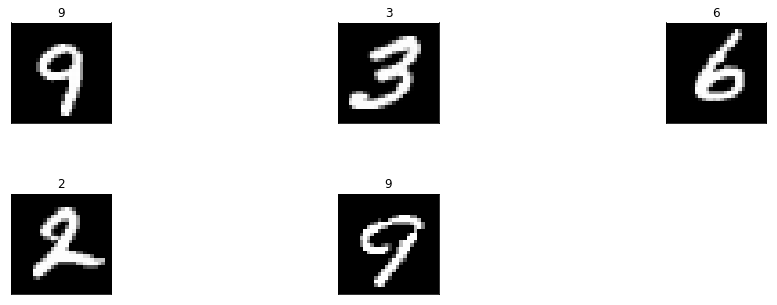

In [30]:
# Load new images.
new_datapoint_cnt = 5
ix_offset = 13
X_new = X_test[ix_offset:new_datapoint_cnt + ix_offset, :]
y_new = y_test[ix_offset:new_datapoint_cnt + ix_offset]

# Plot new images.
plot_images(X_new, y_new, english_labels=None)
#plt.savefig('./fig/new_images.png')

### Predictions and Top 5 Softmax Probabilities for Each Image

INFO:tensorflow:Restoring parameters from ./kjo_net.testing.ckpt

Image 0
  Truth class 9
  Predicted class 9


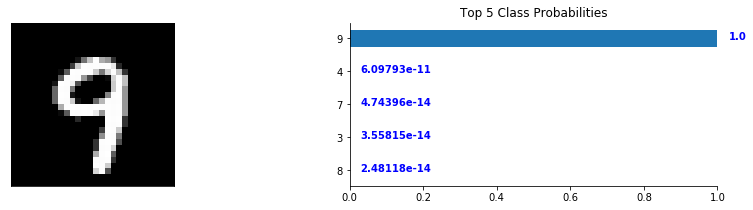


Image 1
  Truth class 3
  Predicted class 3


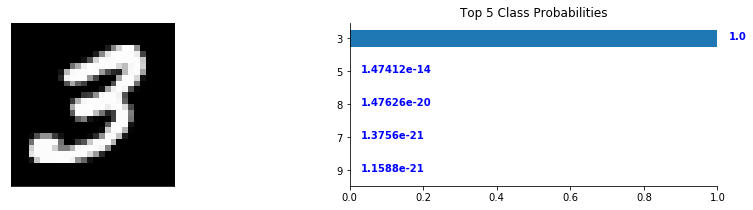


Image 2
  Truth class 6
  Predicted class 6


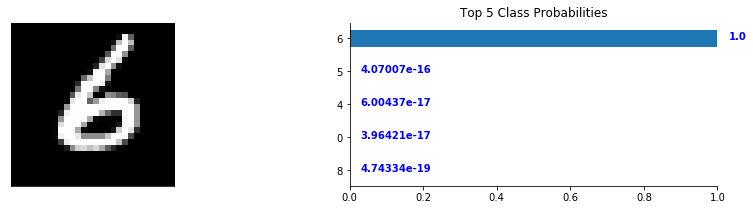


Image 3
  Truth class 2
  Predicted class 2


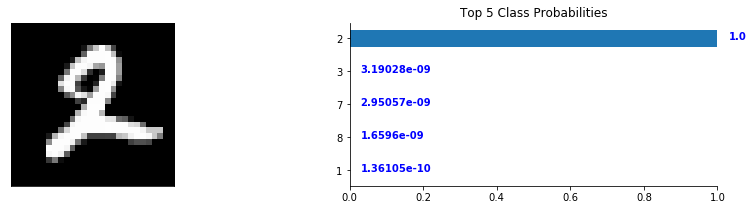


Image 4
  Truth class 9
  Predicted class 9


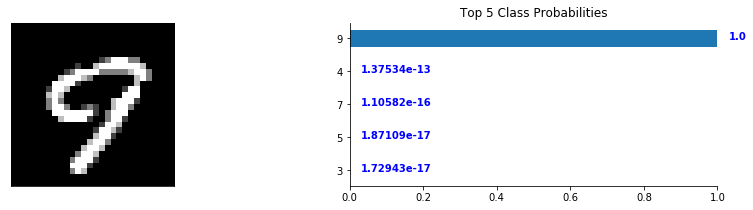

Test Accuracy on new images = 1.000


In [31]:
X_new_in = preprocess(X_new)

with tf.Session() as session:
    #session.run(tf.global_variables_initializer())
    #saver = tf.train.import_meta_graph('kjo_net.meta')
    #saver.restore(session, tf.train.latest_checkpoint('.'))
    saver.restore(session, testing_save_filename)
    top_k = session.run(
        tf.nn.top_k(tf.nn.softmax(logits), k=5),
        feed_dict={X_in: X_new_in, keep_probability: 1.0})
    test_accuracy = compute_accuracy(session, X_new_in, y_new)
    
# Plot softmax probabilities.
ixs = np.arange(X_new.shape[0])
probabilities, classes = top_k
probability_barh_width = 14.5
probability_barh_height = 3
for i, image in enumerate(X_new):
    
    print('\nImage %g\n  Truth class %g\n  Predicted class %g' % \
      (i, y_new[i], top_k[1][i, 0]))

    fig, axes = plt.subplots(
        1, 2, figsize=(probability_barh_width, probability_barh_height))
    plt.subplot(1, 2, 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    plt.subplot(1, 2, 2)
    ax = plt.gca()
    plt.barh(ixs, probabilities[i], height=0.5, align='center')
    y_tick_labels = []    
    for j in ixs: 
        label = str(classes[i][j])
        y_tick_labels.append(truncate_string(label, ubnd=25))
    plt.yticks( ixs, y_tick_labels)
    plt.title('Top 5 Class Probabilities')
    #plt.xlabel('Probability')
    #ax = plt.gca(); ax.set_xscale('log') 
    ax.invert_yaxis()
    for i, value in enumerate(probabilities[i]):
        ax.text(value + 0.03, i + .03, str(value), color='blue', fontweight='bold')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.xlim(0.0, 1.0)
    
    plt.show();
    #plt.savefig('./fig/new_image-%03g.top_softmax_probabilities.png' % i)
    
print('Test Accuracy on new images = {:.3f}'.format(test_accuracy)) 

### Performance Analysis

For these 5 images, the final classifier performed perfectly. However, plots of the top 5 softmax probabilities reveal that there was a small amount of uncertainty in some of the classifications. As one would expect, the classes assigned the highest probabilities in each case correspond to digits that can look similar even to humans, especially dependent on the handwriting.

## 6&nbsp;&nbsp;&nbsp;Conclusions

In this project, I showed a successful TensorFlow implementation of a deep CNN (Convolutional Neural Network) for classifying numeric digits based on the MNIST dataset.  The architecture was chosen by scaling up LeNet-5 [1] and adding dropout regularization. This achieved ??.?% classification accuracy on the MNIST test set. Examining the top few softmax probabilities for 5 individual images showed that the CNN did have a small amount of uncertainty in distinguishing between digits that were geometrically similar and look similar even to humans.

### Limitations, Weaknesses, and Future Work

While ??.?% accuracy is a significant improvement over the ??.?% accuracy of the baseline CNN, there is still room for improvement. For the next version of the CNN, I would consider the following modifications.

 * Change the input to include precomputed Canny edges.  

 * Try topologically different architectures, e.g., feed-forward from the first convolution to the first fully connected layer.

 * Gather more data and/or use more sophisticated data augmentation.

## References

[0] Y. LeCun and C. Cortes and C. J. C. Burges, [The MNIST Database of Handwritten Digits](http://yann.lecun.com/exdb/mnist/)

[1] Y. LeCun and L. Bottou and Y. Bengio and P. Haffner, [Gradient-Based Learning Applied to Document Recognition](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf), Proceedings of the IEEE, 86(11):2278-2324, November 1998. Note: Lenet-5.

[2] G. E Hinton and N. Srivastava and A. Krizhevsky and I. Sutskever and R. R. Salakhutdinov, "Improving neural networks by preventing co-adaptation of feature detectors", ArXiv preprint, [https://arxiv.org/abs/1207.0580](https://arxiv.org/abs/1207.0580). Note: Dropout.